# Decision Trees
Follow _Introduction to Machine Learning_ [Chapter 2 Supervised Learning](https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb) **Section 2.3.5 Decision Trees** (p.72)

**Note:**
This file uses the `graphviz` and `python-graphviz` packages - make sure you have installed them in your conda environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## What is a decision tree? 

In [2]:
import mglearn

In [3]:
mglearn.plots.plot_animal_tree()

ModuleNotFoundError: No module named 'graphviz'

A binary tree, that splits data using a series of yes-no questions.

## Decision tree classifier 

**Non-linear** decision boundaries.

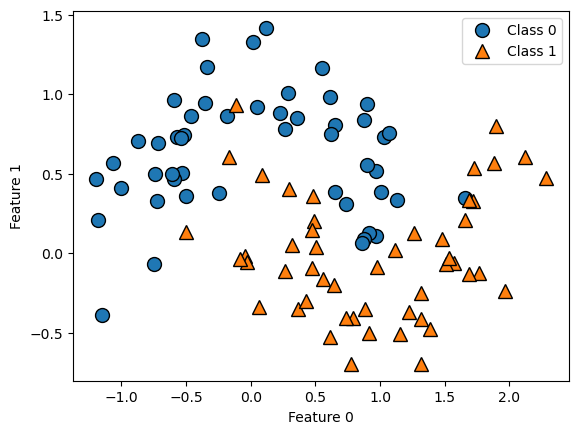

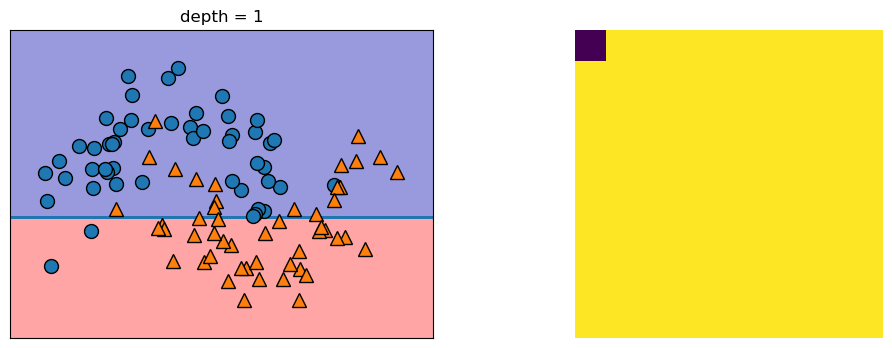

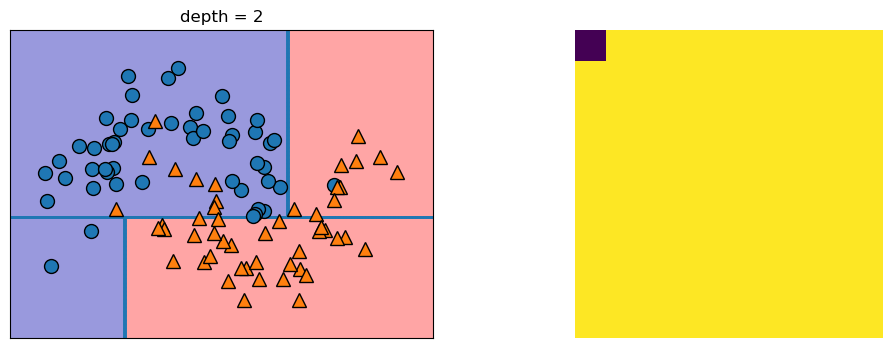

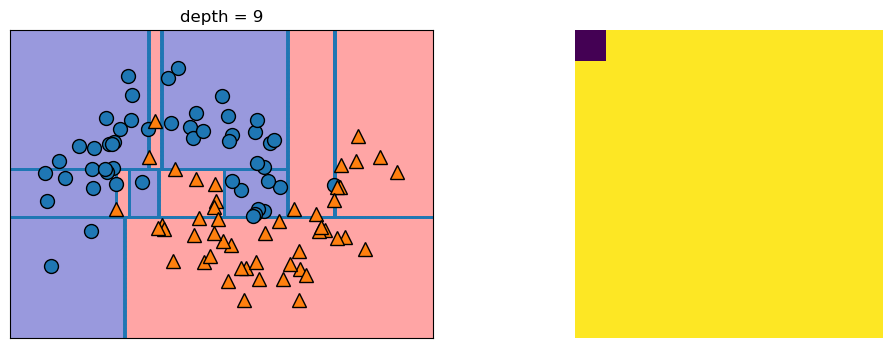

In [4]:
mglearn.plots.plot_tree_progressive()

In general, decision trees are build using the following steps:

- At every node, all features are iterated.  
- For each feature, all levels are iterated.  
- For all levels, the split is performed and the *goodness* of the split is calculated.  
- The feature and level resulting in the best split is kept.
- This process continuous recursively.

Different formulas to define *goodness* of split are available. For classification,  entropy and gini impurity are popular. For regression, mean-squared error and mean-absolute error are possibilities.

### Controlling complexity of decision trees

There are several hyperparameters that influence complexity of a decision tree. An effective parameter is limiting the depth, the number of levels a tree has, using the `max_depth` parameter. 

**Reduced** depth results in a **lower** complexity model.

Fully grown tree:

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_val, y_train, y_val = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on validation set: {:.3f}".format(tree.score(X_val, y_val)))
print("Max depth of decision tree:", tree.tree_.max_depth)

Accuracy on training set: 1.000
Accuracy on validation set: 0.937
Max depth of decision tree: 7


Limiting the number of levels to 4:

In [6]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on validation set: {:.3f}".format(tree.score(X_val, y_val)))

Accuracy on training set: 0.988
Accuracy on validation set: 0.951


### Analyzing decision trees
Decision trees can be visualized nicely to understand better how classifications are made.

Value shows how many samples per class.

Class indicates majority class.

In [7]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=True, filled=True)

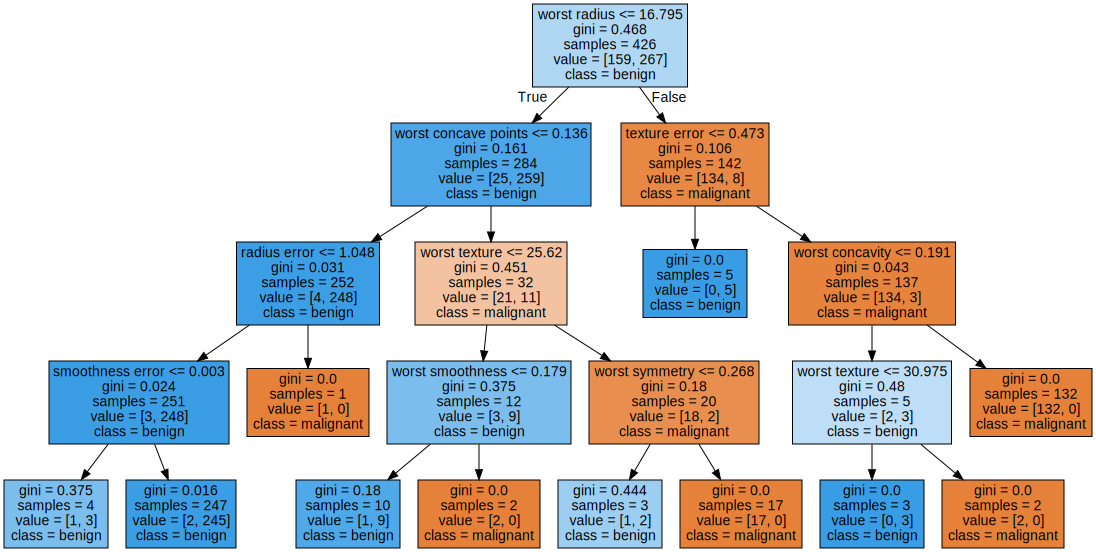

In [10]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Feature importance 

For each feature, a value between 0 (not used at all) and 1 (perfectly predicts the target) is calculated and available in the `feature_importances_` attribute of the model object. Importances for all features add up to 1 (normalized).

From the documentation:
>The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_


In [11]:
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


In [12]:
print(sum(tree.feature_importances_))

1.0


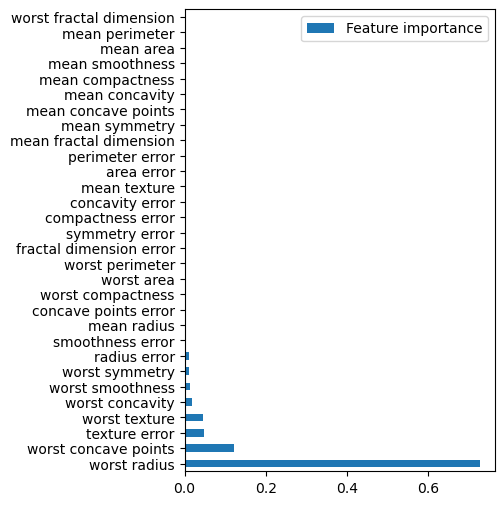

In [13]:
def plot_feature_importances_cancer(model, figsize=(4,6)):
    importances = pd.DataFrame({'Feature importance': model.feature_importances_}, 
                           index=cancer.feature_names).sort_values(by='Feature importance',ascending=False)
    importances.plot.barh(figsize=figsize);

plot_feature_importances_cancer(tree)

Note that importances are always positive. They do not indicate if a larger value is more indicative of one class over the other. For example, *worst radius* is important, but we do not know if a larger *worst radius* is indicative of a *malignant* tumor.

Furthermore, even if one feature is uniquely utilized, there might not be a monotone relationship, i.e. higher values of the features means class 1 and lower values result in class 0. This is illustrated below.

Feature importances: [0. 1.]


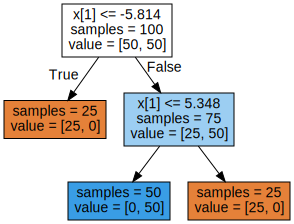

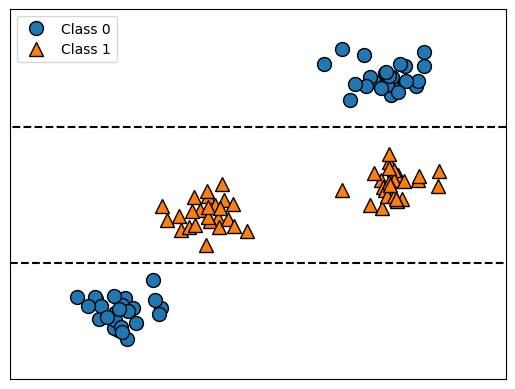

In [14]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

### Regression 

Decision trees can be used for regression too. Each node holds the average value of the corresponding samples.

Splits are evaluated based on mean-squared error. Subsequent levels (should) result in reduced mean-squared errors.

Unlike linear regression, decision trees cannot be utilized for extrapolation, as illustrated below.

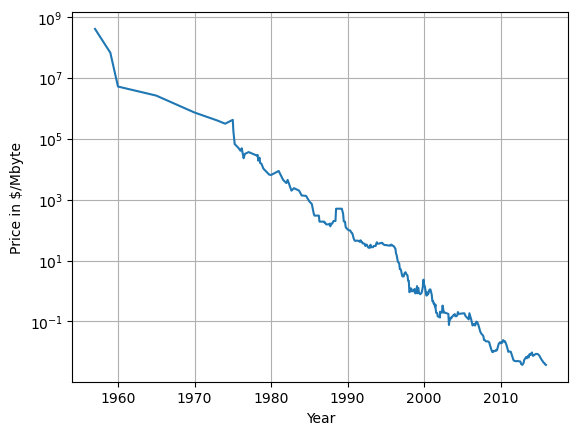

In [15]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
    
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")
plt.grid(True)

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date
X_train = np.array(data_train.date)[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = np.array(ram_prices.date)[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

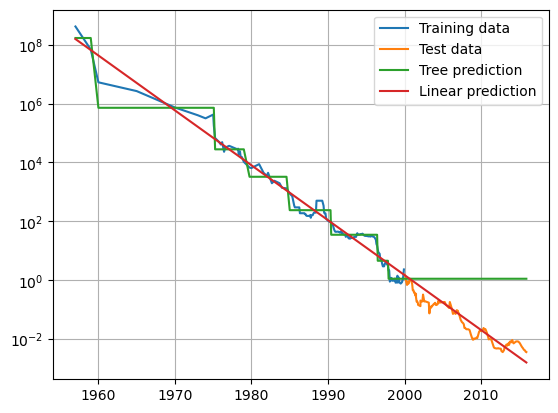

In [17]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()
plt.grid(True)

### Visualizing a regression tree

In [18]:
export_graphviz(tree, out_file="regression_tree.dot", impurity=True, filled=True)

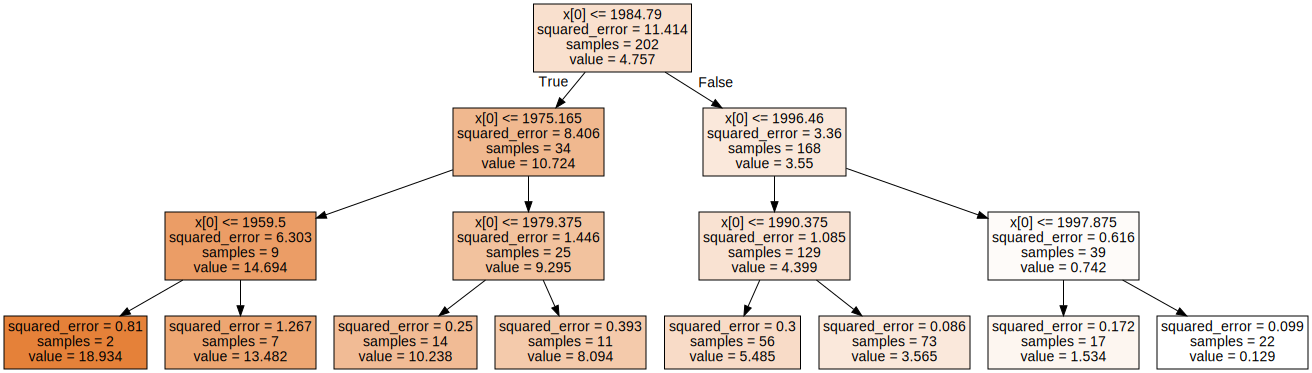

In [19]:
with open("regression_tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))